In [79]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
#download data
!aws s3 cp s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet NFL_PBP_Data_2010_2022_original.parquet

In [8]:
#Load Data
df = pd.read_parquet('NFL_PBP_Data_2010_2022_original.parquet', engine='pyarrow')
df.head()
print(df.shape)

download: s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet to ./NFL_PBP_Data_2010_2022_original.parquet
(588078, 384)


# Data Cleanup

In [9]:
df = df[df['play_type'].isin(['pass', 'run', 'punt', 'extra_point', 'field_goal']) ]
df = df[~(df['game_half'] == 'Overtime' )]

(465333, 384)


In [10]:
def transform_off_personnel(row):

   rb_count = 0
   te_count = 0
   wr_count = 0
   ol_count = 0
   dl_count = 0
   db_count = 0

   if not pd.isna(row['offense_personnel']):
       personnel = row['offense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'RB':
               rb_count = int(p[0])
           elif p[2:4] == 'TE':
                te_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
               db_count = int(p[0])

   return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count])

df[['off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count', 'off_db_count']] = df.apply(transform_off_personnel, axis=1)

In [12]:
def transform_def_personnel(row):

   dl_count = 0
   db_count = 0
   lb_count = 0
   rb_count = 0
   wr_count = 0
   ol_count = 0
   
   if not pd.isna(row['defense_personnel']):
       personnel = row['defense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'LB':
                lb_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
                db_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'RB':
                rb_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
                
   return pd.Series([dl_count,db_count,lb_count,rb_count,wr_count,ol_count])

df[['def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count']] = df.apply(transform_def_personnel, axis=1)

In [14]:
def PlayType_normalized(s):
  if s['play_type_nfl'] == 'PASS': 
    return 'PASS'
  elif s['play_type_nfl'] == 'RUSH': 
    return 'RUSH'
  else:
    return 'OTHER'
df['PlayType_normalized'] = df.apply(PlayType_normalized, axis=1)

In [17]:
df = df[~(df['PlayType_normalized'] == 'OTHER' )]

In [19]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['yardline_binned'] = pd.cut(df['yardline_100'], bins)

In [20]:
print(df.shape)

(392032, 398)


# Data Inspection

In [21]:
for c in df.columns: 
    print(c)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [28]:
display(df[['ydsnet', 'yards_gained']].head())

,ydsnet,yards_gained
2,53.0,0.0
3,53.0,5.0
4,53.0,18.0
5,53.0,17.0
6,53.0,2.0


(array([3.0000e+01, 1.0450e+03, 2.6323e+04, 6.1294e+04, 5.0888e+04,
        5.0127e+04, 5.1623e+04, 5.6520e+04, 7.7388e+04, 1.5585e+04]),
 array([-39.        , -25.20000076, -11.39999962,   2.4000001 ,
         16.20000076,  30.        ,  43.79999924,  57.59999847,
         71.40000153,  85.19999695,  99.        ]),
 <BarContainer object of 10 artists>)

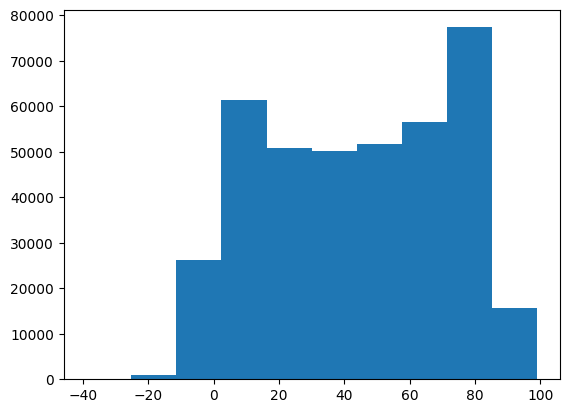

In [30]:
plt.hist(df[['ydsnet']])

(array([1.00000e+01, 6.72700e+03, 3.09733e+05, 5.78500e+04, 1.18510e+04,
        3.59100e+03, 1.33600e+03, 5.72000e+02, 2.99000e+02, 6.30000e+01]),
 array([-28.        , -15.30000019,  -2.5999999 ,  10.10000038,
         22.79999924,  35.5       ,  48.20000076,  60.90000153,
         73.59999847,  86.30000305,  99.        ]),
 <BarContainer object of 10 artists>)

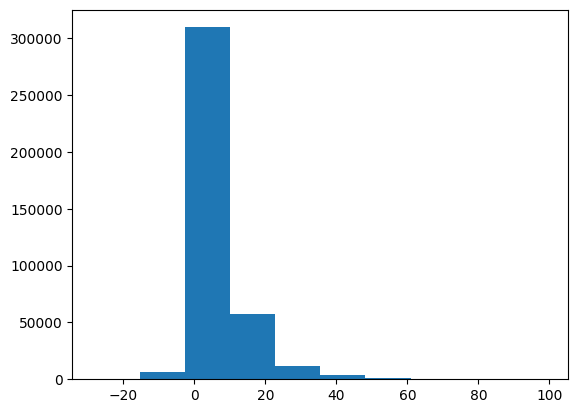

In [31]:
plt.hist(df[['yards_gained']])

# Feature Selection

In [60]:
# nfl_final = nfl_df[['play_id','game_id','home_team','away_team','PlayType_normalized','PlayType_normalized_binary','season_type','posteam','down','ydstogo','yardline_100','yardline_binned',
#                    'offense_personnel','off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count','off_db_count',
#                    'defense_personnel','def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count',
#                     'offense_formation','defenders_in_box'
#                    ]]

select_list = ['yards_gained', 'home_team', 'away_team', 'PlayType_normalized', 'season_type', 'posteam', 'quarter_seconds_remaining', 
               'half_seconds_remaining', 'game_seconds_remaining', 'down', 'score_differential', 'away_score', 'home_score', 
                'wind']

df_model = df[select_list]
df_model['wind'].fillna(0, inplace=True)

/tmp/ipykernel_153/3586822603.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['wind'].fillna(0, inplace=True)


In [61]:
df_model.describe()

,yards_gained,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,score_differential,away_score,home_score,wind
count,392032.000000,392032.000000,392032.000000,392032.000000,392032.000000,392032.000000,392032.000000,392032.000000,392032.000000
mean,6.001487,435.401306,852.625244,1752.175293,1.782803,-1.486708,22.040953,24.053710,5.428692
std,8.614878,270.127045,541.935181,1045.848022,0.816187,10.879809,9.926051,10.300547,5.772680
min,-28.000000,0.000000,0.000000,0.000000,1.000000,-58.000000,0.000000,0.000000,0.000000
25%,0.000000,190.000000,359.000000,852.000000,1.000000,-7.000000,15.000000,17.000000,0.000000
50%,3.000000,426.000000,850.000000,1800.000000,2.000000,0.000000,22.000000,24.000000,5.000000
75%,9.000000,670.000000,1323.000000,2648.000000,2.000000,4.000000,28.000000,31.000000,9.000000
max,99.000000,900.000000,1800.000000,3600.000000,4.000000,55.000000,59.000000,62.000000,71.000000


In [62]:
df_model.head()

,yards_gained,home_team,away_team,PlayType_normalized,season_type,posteam,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,down,score_differential,away_score,home_score,wind
2,0.0,LA,ARI,PASS,REG,ARI,895.0,1795.0,3595.0,1.0,0.0,17,13,0
3,5.0,LA,ARI,RUSH,REG,ARI,864.0,1764.0,3564.0,2.0,0.0,17,13,0
4,18.0,LA,ARI,PASS,REG,ARI,823.0,1723.0,3523.0,3.0,0.0,17,13,0
5,17.0,LA,ARI,PASS,REG,ARI,797.0,1697.0,3497.0,1.0,0.0,17,13,0
6,2.0,LA,ARI,RUSH,REG,ARI,772.0,1672.0,3472.0,1.0,0.0,17,13,0


# Modeling

## Optimize for yards_gained

In [63]:
train_df, test_df = train_test_split(df_model, test_size=.20)

In [64]:
lr_model = LinearRegression()
enc = OneHotEncoder()

In [71]:
encoding_list = ['home_team', 'away_team', 'PlayType_normalized', 'season_type', 'posteam']

transformer = make_column_transformer(
    (OneHotEncoder(), encoding_list),
    remainder='passthrough'
)

transformed = transformer.fit_transform(train_df)

train_df_t = pd.DataFrame(
    transformed.toarray(), 
    columns=transformer.get_feature_names_out()
)

feature_list = transformer.get_feature_names_out()[transformer.get_feature_names_out() != 'remainder__yards_gained']
outcome = ['remainder__yards_gained']


display(train_df_t)
lr_model.fit(train_df_t[feature_list], train_df_t[outcome])

,onehotencoder__home_team_ARI,onehotencoder__home_team_ATL,onehotencoder__home_team_BAL,onehotencoder__home_team_BUF,onehotencoder__home_team_CAR,onehotencoder__home_team_CHI,onehotencoder__home_team_CIN,onehotencoder__home_team_CLE,onehotencoder__home_team_DAL,onehotencoder__home_team_DEN,...,onehotencoder__posteam_WAS,remainder__yards_gained,remainder__quarter_seconds_remaining,remainder__half_seconds_remaining,remainder__game_seconds_remaining,remainder__down,remainder__score_differential,remainder__away_score,remainder__home_score,remainder__wind
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,5.0,626.0,1526.0,1526.0,2.0,1.0,16.0,23.0,9.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,9.0,169.0,169.0,169.0,1.0,-4.0,10.0,14.0,15.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,724.0,1624.0,1624.0,1.0,-11.0,17.0,12.0,13.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,39.0,792.0,1692.0,1692.0,1.0,14.0,17.0,10.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,159.0,1059.0,1059.0,3.0,0.0,16.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,11.0,559.0,559.0,559.0,1.0,-3.0,9.0,12.0,5.0
313621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,794.0,1694.0,3494.0,1.0,0.0,44.0,17.0,0.0
313622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,120.0,120.0,1920.0,2.0,13.0,9.0,35.0,11.0
313623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,771.0,771.0,771.0,1.0,-6.0,42.0,47.0,0.0


LinearRegression()

In [75]:
test_transformed = transformer.transform(test_df)
test_df_t = pd.DataFrame(
    test_transformed.toarray(), 
    columns=transformer.get_feature_names_out()
)
predictions = lr_model.predict(test_df_t[feature_list])

In [77]:
print(predictions)

[[6.76281285]
 [4.88279808]
 [6.94956958]
 ...
 [4.04572725]
 [3.72944438]
 [7.91930008]]


In [81]:
mean_squared_error(test_df_t[outcome], predictions, squared=False)

8.529806313839803

* Add in player values
* Standardize ranges of input variables
* modeling for 1st down likelyhood
* modeling for touchdown likelyhood